In [2]:
import torch as torch
import pandas as pd
import numpy as np
from sklearn import preprocessing
from neuralnetwork import *
from reading import *
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

torch.cuda.set_device(1)
device = ("cuda:1" if torch.cuda.is_available() else"cpu")
print(f"Using {device} from {torch.cuda.get_device_name()}")

Using cuda:1 from NVIDIA GeForce RTX 2080 Ti


In [3]:
dataCell = domain_selection(2)
print("_________________________")
dataPatient = domain_selection(3)
print("_________________________")
cellDataloaders, input_dim = arrange_data_into_dataloaders(dataCell, device=device)
print("_________________________")
patientDataloaders, input_dim = arrange_data_into_dataloaders(dataPatient, device=device)
output_dim = 1
net1 = Network(input_dim,output_dim).to(device)
loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(net1.parameters(), lr=0.0001)

Selection Cell domain source
All done
Name of the variable containing all cell data : cell_data
_________________________
Selection Patient domain source
All done
Name of the variable containing all the data : Patient_data
_________________________
6643 elements in the dataset
4649 elements in trainset
997 elements in valset
997 elements in testset
_________________________
21244 elements in the dataset
14870 elements in trainset
3187 elements in valset
3187 elements in testset


In [4]:
X_fc1=[]
X_fc2=[]
X_fc3=[]

In [5]:
label_patient= []
for i in patientDataloaders[0]:
    _,y = i
    for j in range(len(y)):
        label_patient.append(y[j].cpu().clone().numpy())
label_cell= []
for i in cellDataloaders[0]:
    _,y = i
    for j in range(len(y)):
        label_cell.append(y[j].cpu().clone().numpy())
        
Y_label_domain=[]
for i in range(len(label_patient)):
    if label_patient[i]==0:
        Y_label_domain.append(0)
    else :
        Y_label_domain.append(1)

for i in range(len(label_cell)):
    if label_cell[i]==0:
        Y_label_domain.append(2)
    else :
        Y_label_domain.append(3)

Y_label_domain = np.array(Y_label_domain)

0 = Patient.Normal || 1 = Patient.Cancer || 2 = Cell.Normal || 3 = Cell.Cancer

# Entrainement Patient ----> Prédiction Cell

In [6]:
tqdm(mean_network(100,1, net1, patientDataloaders,cellDataloaders))

0/1 réseau
Pre-training net done in : 68.395596317econds ||  
 Val Loss=1.0470 | Val Acc=0.7503   ||   Test Loss=1.1576 | Test Acc=0.7242


  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
net1.fc1.register_forward_hook(forward_hook(X_fc1))
net1.fc2.register_forward_hook(forward_hook(X_fc2))
net1.fc3.register_forward_hook(forward_hook(X_fc3))

In [8]:
_ = evaluate_epoch( net1, cellDataloaders[0],loss_function)

In [9]:
X_cell_fc1, Y_cell_fc1 = construct_list_hook(X_fc1, cellDataloaders)
X_cell_fc2, Y_cell_fc2 = construct_list_hook(X_fc2, cellDataloaders)
X_cell_fc3, Y_cell_fc3 = construct_list_hook(X_fc3, cellDataloaders)

In [10]:
X_fc1.clear()
X_fc2.clear()
X_fc3.clear()

In [11]:
_ = evaluate_epoch( net1, patientDataloaders[0], loss_function)

In [12]:
X_patient_fc1, Y_patient_fc1 = construct_list_hook(X_fc1, patientDataloaders)
X_patient_fc2, Y_patient_fc2 = construct_list_hook(X_fc2, patientDataloaders)
X_patient_fc3, Y_patient_fc3 = construct_list_hook(X_fc3, patientDataloaders)

In [13]:
scaler = StandardScaler()

Xs_cell_fc1 = scaler.fit_transform(X_cell_fc1)
Xs_cell_fc2 = scaler.fit_transform(X_cell_fc2)
Xs_cell_fc3 = scaler.fit_transform(X_cell_fc3)

Xs_patient_fc1 = scaler.fit_transform(X_patient_fc1)
Xs_patient_fc2 = scaler.fit_transform(X_patient_fc2)
Xs_patient_fc3 = scaler.fit_transform(X_patient_fc3)

pca2D = PCA(n_components=2)

Xt_cell_fc1 = pca2D.fit_transform(Xs_cell_fc1)
Xt_cell_fc2 = pca2D.fit_transform(Xs_cell_fc2)
Xt_cell_fc3 = pca2D.fit_transform(Xs_cell_fc3)

Xt_patient_fc1 = pca2D.fit_transform(Xs_patient_fc1)
Xt_patient_fc2 = pca2D.fit_transform(Xs_patient_fc2)
Xt_patient_fc3 = pca2D.fit_transform(Xs_patient_fc3)

In [14]:
distribution =[]
for i in range(len(X_patient_fc1)):
    distribution.append(1)

for i in range(len(X_cell_fc1)):
    distribution.append(0)

In [15]:
X_all_fc1 = X_patient_fc1 + X_cell_fc1
X_all_fc2 = X_patient_fc2 + X_cell_fc2
X_all_fc3 = X_patient_fc3 + X_cell_fc3

Xs_all_fc1 = scaler.fit_transform(X_all_fc1)
Xs_all_fc2 = scaler.fit_transform(X_all_fc2)
Xs_all_fc3 = scaler.fit_transform(X_all_fc3)

Xt_all_fc1 = pca2D.fit_transform(Xs_all_fc1)
Xt_all_fc2 = pca2D.fit_transform(Xs_all_fc2)
Xt_all_fc3 = pca2D.fit_transform(Xs_all_fc3)

# PCA

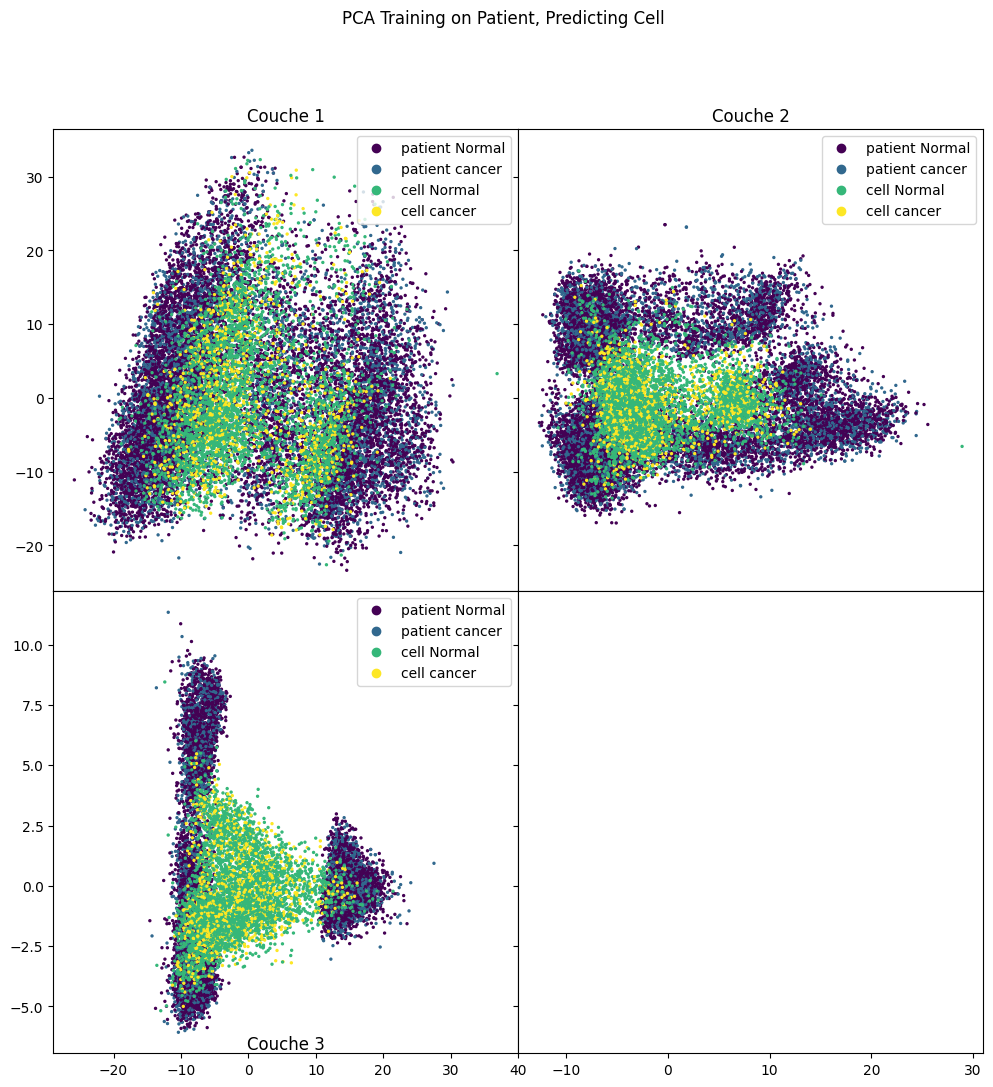

In [17]:
fig4 = plt.figure(figsize=(12,12))
fig4.suptitle("PCA Training on Patient, Predicting Cell")
gs = fig4.add_gridspec(2,2, hspace=0,wspace=0)
(ax1, ax2),(ax3,ax4) = gs.subplots(sharex='col', sharey='row')
scatter = ax1.scatter(Xt_all_fc1[:,0],Xt_all_fc1[:,1], s=2,c=Y_label_domain)
ax1.legend(handles = scatter.legend_elements()[0], labels=['patient Normal','patient cancer','cell Normal','cell cancer'])
ax1.set_title('Couche 1')
scatter = ax2.scatter(Xt_all_fc2[:,0],Xt_all_fc2[:,1], s=2,c=Y_label_domain)
ax2.legend(handles = scatter.legend_elements()[0], labels=['patient Normal','patient cancer','cell Normal','cell cancer'])
ax2.set_title("Couche 2")
scatter = ax3.scatter(Xt_all_fc3[:,0],Xt_all_fc3[:,1], s=2,c=Y_label_domain)
ax3.legend(handles = scatter.legend_elements()[0], labels=['patient Normal','patient cancer','cell Normal','cell cancer'])
ax3.set_title("Couche 3", y=-0.01)
for ax in fig4.get_axes():
    ax.label_outer()
fig4.savefig("MLP_PCA_Patient_to_cell_domain_and_label.png")

# UMAP

In [ ]:
import umap.plot
import umap

In [ ]:
%%time
mapper_fc1 = umap.UMAP(n_neighbors=15, min_dist=0.1,n_components=2).fit(Xs_all_fc1)
mapper_fc2 = umap.UMAP(n_neighbors=15, min_dist=0.1,n_components=2).fit(Xs_all_fc2)
mapper_fc3 = umap.UMAP(n_neighbors=15, min_dist=0.1,n_components=2).fit(Xs_all_fc3)

In [ ]:
distribution = np.array(distribution)

In [ ]:
umap.plot.points(mapper_fc1, labels=distribution, color_key_cmap='Paired')

In [ ]:
umap.plot.points(mapper_fc2, labels=distribution, color_key_cmap='Paired')

In [ ]:
umap.plot.points(mapper_fc3, labels=distribution, color_key_cmap='Paired')

# T-SNE

In [18]:
from sklearn.manifold import TSNE

In [19]:
Xe_all_fc1 = TSNE().fit_transform(Xs_all_fc1)
Xe_all_fc2 = TSNE().fit_transform(Xs_all_fc2)
Xe_all_fc3 = TSNE().fit_transform(Xs_all_fc3)

/home/bcombe/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/bcombe/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/bcombe/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/bcombe/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/bcombe/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/bcombe/pytorch/lib/python3.7/site-packages/sk

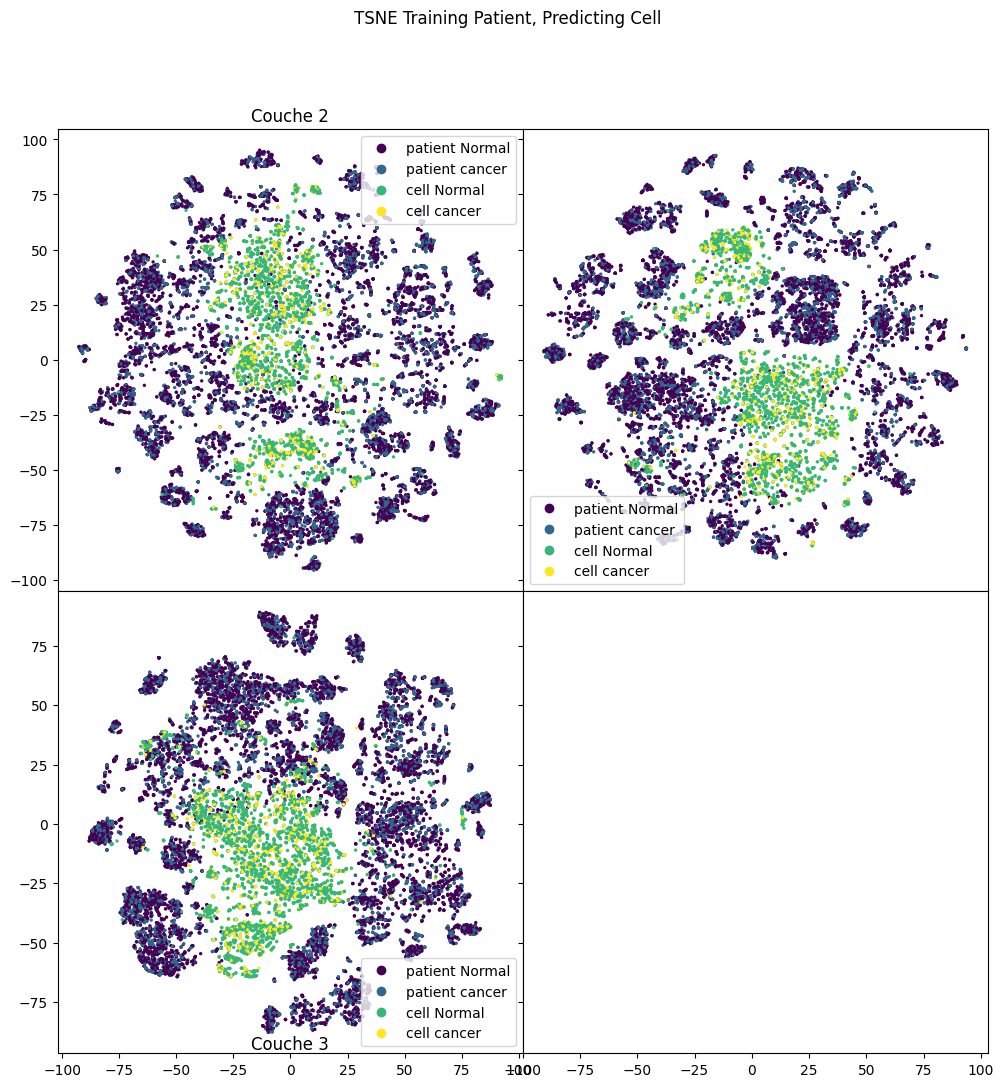

In [22]:
fig5 = plt.figure(figsize=(12,12))
fig5.suptitle("TSNE Training Patient, Predicting Cell")
gs = fig5.add_gridspec(2,2, hspace=0,wspace=0)
(ax1, ax2),(ax3,ax4) = gs.subplots(sharex='col', sharey='row')
scatter = ax1.scatter(Xe_all_fc1[:,0],Xe_all_fc1[:,1], s=2,c=Y_label_domain)
ax1.legend(handles = scatter.legend_elements()[0], labels=['patient Normal','patient cancer','cell Normal','cell cancer'])
ax1.set_title("Couche 1")
scatter = ax2.scatter(Xe_all_fc2[:,0],Xe_all_fc2[:,1], s=2,c=Y_label_domain)
ax2.legend(handles = scatter.legend_elements()[0], labels=['patient Normal','patient cancer','cell Normal','cell cancer'])
ax1.set_title("Couche 2")
scatter = ax3.scatter(Xe_all_fc3[:,0],Xe_all_fc3[:,1], s=2,c=Y_label_domain)
ax3.legend(handles = scatter.legend_elements()[0], labels=['patient Normal','patient cancer','cell Normal','cell cancer'])
ax3.set_title("Couche 3", y=-0.01)
for ax in fig5.get_axes():
    ax.label_outer()
fig5.savefig("MLP_TSNE_Patient_to_cell_domain_and_label.png")